# Logist Regression Approach (Sign Language Digits Dataset)
    
## Introduction

This notebook is a simple approach to the Sign Language Digits Dataset using Logistic Regression. The dataset consists of 2062 64x64 images of hand signs representing numbers from 0 to 9. The goal is to classify the images into the correct number using logistic regression. We will use the accuracy score as the metric to evaluate the model pair with the confusion matrix, F1 score, precision and recall. We will also test with PCA to see if it improves the model.



## Libraries

We will use the following libraries:

In [14]:
import numpy as np
import matplotlib.pyplot as plt
import imgaug.augmenters as iaa
import os
import seaborn as sns
from sklearn.decomposition import PCA
from datetime import datetime
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score, f1_score
import itertools

## Data Loading

Load the data, which consists of features (X) and labels (Y), from `.npy` files.

In [15]:
X_original = np.load('archive/X.npy')
Y_original = np.load('archive/Y.npy')

print(X_original.shape)
print(Y_original.shape)

(2062, 64, 64)
(2062, 10)


## Organização dos Dados


In [16]:
def save_dataset_with_timestamp(X, Y, prefix='archive/X', suffix='archive/Y'):
    timestamp = datetime.now().strftime('%Y-%m-%d_%H-%M-%S')
    np.save(f'{prefix}_{timestamp}.npy', X)
    np.save(f'{suffix}_{timestamp}.npy', Y)

X = np.copy(X_original)
Y = np.copy(Y_original)

# Mapping classes to the correct digits
# class 0 = digit 9, class 1 = digit 0, class 2 = digit 7, class 3 = digit 6, class 4 = digit 1, class 5 = digit 8, class 6 = digit 4, class 7 = digit 3, class 8 = digit 2, class 9 = digit 5

class_to_digit = {0: 9, 1: 0, 2: 7, 3: 6, 4: 1, 5: 8, 6: 4, 7: 3, 8: 2, 9: 5}

# Convert Y from one-hot encoding to class indices
labels_indices = np.argmax(Y, axis=1)

# Correct the indices based on the mapping
correted_labels = np.array([class_to_digit[label] for label in labels_indices])

# Convert back to one-hot encoding
correted_Y = np.eye(10)[correted_labels]

print('Labels corrigidos: ', correted_labels[:2000])

# Sort the dataset by the digit each sample represents
sorted_indices = np.argsort(correted_labels)

print('Labels ordenados: ', correted_labels[sorted_indices])


# ordenar os labels
correted_Y = correted_Y[sorted_indices]
correted_X = X[sorted_indices]

# salvar os dados
save_dataset_with_timestamp(correted_X, correted_Y)


Labels corrigidos:  [9 9 9 ... 5 5 5]
Labels ordenados:  [0 0 0 ... 9 9 9]


## Sample Distribution Analysis

To understand the balance between different classes in our dataset, it's useful to visualize the distribution of samples across classes. This helps in identifying if there's a class imbalance that might affect model training.

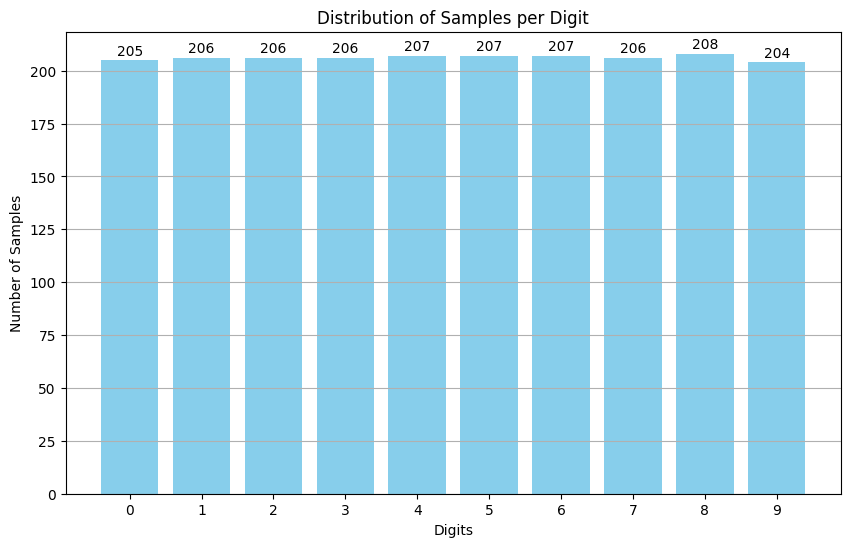

In [17]:
# Count the number of samples per digit
samples_per_digit = np.bincount(correted_labels[sorted_indices])

# Unique classes (assuming classes are sequential and start from 0)
unique_classes = np.arange(len(samples_per_digit))

#Print the number of samples per class
# print('Number of samples per class:')
# for i in range(len(samples_per_digit)):
#     print(f'Class {i}: {samples_per_digit[i]} samples')

# Create a histogram to visualize the distribution of samples per class
plt.figure(figsize=(10, 6))
plt.bar(unique_classes, samples_per_digit, color='skyblue')
for i in range(len(samples_per_digit)):
    plt.text(i, samples_per_digit[i] + 1, str(samples_per_digit[i]), ha='center', va='bottom')
plt.xlabel('Digits')
plt.ylabel('Number of Samples')
plt.title('Distribution of Samples per Digit')
plt.xticks(unique_classes)
plt.grid(axis='y')

plt.show()

## Splitting the Data

We will split the data into training and testing sets using the `train_test_split` function from the `sklearn` library.

In [18]:
# # We are going to create a training,test and validation array, 70% - training, 15% - test, 15% - cross validation

#reshape Y
correted_Y = np.argmax(correted_Y, axis=1)
correted_Y = correted_Y.reshape(-1, 1)

# reshape dataset to 2D, removing the third dimension
X_flatten = correted_X.reshape(correted_X.shape[0], correted_X.shape[1] * correted_X.shape[2])

# Split the dataset into training and test sets
X_train, X_test, Y_train, Y_test = train_test_split(X_flatten, correted_Y, test_size=0.3, random_state=42)

# Split the test set into test and validation sets
X_test, X_val, Y_test, Y_val = train_test_split(X_test, Y_test, test_size=0.5, random_state=42)

# Print the shapes of the training, test and validation sets
print(f'X_train shape: {X_train.shape}')
print(f'Y_train shape: {Y_train.shape}')

print(f'X_test shape: {X_test.shape}')
print(f'Y_test shape: {Y_test.shape}')

print(f'X_val shape: {X_val.shape}')
print(f'Y_val shape: {Y_val.shape}')

X_train shape: (1443, 4096)
Y_train shape: (1443, 1)
X_test shape: (309, 4096)
Y_test shape: (309, 1)
X_val shape: (310, 4096)
Y_val shape: (310, 1)


## Logistic Regression Approach (Classes Code)

### Sigmoid

In [19]:
def sigmoid(z):
    """
    return the sigmoid of z
    """
    z = np.clip(z, -20, 20)

    gz = 1/(1 + np.exp(-z))
    
    return gz

### Cost Function Regularized

In [20]:
# def costFunctionReg(X, y, theta, Lambda):
#     m = len(y)
#     h = sigmoid(X @ theta)  # Assume h is (1443, 10) for multiclass
#     error = -y * np.log(h) - (1 - y) * np.log(1 - h)
#     cost = (1 / m) * np.sum(error)
#     regCost = cost + (Lambda / (2 * m)) * np.sum(theta[1:] ** 2)
    
#     reg_term = np.zeros_like(theta)
#     reg_term[1:] = (Lambda / m) * theta[1:]
#     grad = (1 / m) * (X.T @ (h - y)) + reg_term

#     return regCost, grad

def costFunctionReg(X, y, theta, Lambda):
    """
    Take in numpy array of  data X, labels y and theta, to return the regularized cost function and gradients
    of the logistic regression classifier
    """
    
    # number of training examples 
    m = X.shape[0]
        
    # vector of the model predictions for all training examples      
    h = sigmoid(np.dot(X, theta))
    
    epsilon = 1e-5
    error = (-y * np.log(h + epsilon)) - ((1 - y) * np.log(1 - h + epsilon))    
    # cost function without regularization term
    cost = sum(error)/m
    
    # add regularization term to the cost function
    regCost = cost + Lambda/(2*m) * sum(theta[1:]**2)
    
    # gradient of theta_0
    grad_0 = (1/m) * np.dot(X.transpose(),(h - y))[0]
    
    # vector of gradients of theta_j from j=1:n (adding the regularization term of the gradient)
    grad = (1/m) * np.dot(X.transpose(),(h - y))[1:] + (Lambda/m)* theta[1:]
       
    # all gradients in a column vector shape
    grad_all = np.append(grad_0,grad)
    grad_all = grad_all.reshape((len(grad_all), 1))
    
    return regCost[0], grad_all

### Gradient Descent

In [21]:
def gradientDescentWithCostTracking(X, y, X_val, y_val, X_test, y_test, theta, alpha, num_iters, Lambda):
    """
    Take in numpy arrays X, y, X_val, y_val, X_test, y_test, and theta, and update theta by taking num_iters
    gradient steps with learning rate alpha. Lambda is the regularization term.
    Return theta and the lists of the cost of theta during each iteration for the training, validation, and test sets.
    """
    
    J_history_train = []
    J_history_val = []
    J_history_test = []
    
    for i in range(num_iters):
        
        # Calculate the cost and gradient for the training set
        cost_train, grad = costFunctionReg(X, y, theta, Lambda)
        
        # Update theta
        theta = theta - (alpha * grad)
        
        # Calculate the cost for the validation set (no gradient needed)
        cost_val, _ = costFunctionReg(X_val, y_val, theta, Lambda)
        
        # Calculate the cost for the test set (no gradient needed)
        cost_test, _ = costFunctionReg(X_test, y_test, theta, Lambda)
        
        # Save the cost for this iteration
        J_history_train.append(cost_train)
        J_history_val.append(cost_val)
        J_history_test.append(cost_test)
    
    return theta, J_history_train, J_history_val, J_history_test


### One vs All Classification

In [22]:
def trainOneVsAll(X_train, y_train, X_val, y_val, X_test, y_test, initial_theta, alpha, num_iters, Lambda, K):
    all_theta = []
    train_J_history = []
    val_J_history = []
    test_J_history = []

    m, n = X_train.shape
    X_train = np.append(np.ones((m, 1)), X_train, axis=1)
    m_val, _ = X_val.shape
    X_val = np.append(np.ones((m_val, 1)), X_val, axis=1)
    m_test, _ = X_test.shape
    X_test = np.append(np.ones((m_test, 1)), X_test, axis=1)

    for i in range(1, K+1):
        y_train_i = np.where(y_train == i, 1, 0)
        y_val_i = np.where(y_val == i, 1, 0)
        y_test_i = np.where(y_test == i, 1, 0)
        theta, J_history_train, J_history_val, J_history_test = gradientDescentWithCostTracking(X_train, y_train_i, X_val, y_val_i, X_test, y_test_i, initial_theta, alpha, num_iters, Lambda)
        all_theta.append(theta.flatten())
        train_J_history.append(J_history_train)
        val_J_history.append(J_history_val)
        test_J_history.append(J_history_test)

    return np.array(all_theta), train_J_history, val_J_history, test_J_history


### One-vs-all Prediction


In [23]:
def predictOneVsAll(all_theta, X):
    """
    Using all_theta, compute the probability of image X(i) for each class and predict the label
    
    return a vector of prediction
    """
    #number of training examples
    m= X.shape[0]
    
    # add an extra column of 1´s corresponding to xo=1 (aka intercept term)
    X = np.append(np.ones((m,1)),X,axis=1)
    
    predictions = np.dot(X, all_theta.T) # predictions.shape =(5000,10)  X(5000x401) * all_theta(401x10) = 5000x10
    #np.argmax returns indices of the max element of the array in a particular axis.
    #+1 in order to label 0 as 10. 
    return np.argmax(predictions,axis=1)+1

### Plot Confusion Matrix

In [24]:
# Define train and analyse model functions
from sklearn.model_selection import GridSearchCV, KFold, validation_curve, cross_validate


def plot_confusion_matrix(cm,
                          target_names,
                          title='Confusion matrix',
                          cmap=None,
                          normalize=True):
    """
    given a sklearn confusion matrix (cm), make a nice plot

    Arguments
    ---------
    cm:           confusion matrix from sklearn.metrics.confusion_matrix

    target_names: given classification classes such as [0, 1, 2]
                  the class names, for example: ['high', 'medium', 'low']

    title:        the text to display at the top of the matrix

    cmap:         the gradient of the values displayed from matplotlib.pyplot.cm
                  see http://matplotlib.org/examples/color/colormaps_reference.html
                  plt.get_cmap('jet') or plt.cm.Blues

    normalize:    If False, plot the raw numbers
                  If True, plot the proportions

    Usage
    -----
    plot_confusion_matrix(cm           = cm,                  # confusion matrix created by
                                                              # sklearn.metrics.confusion_matrix
                          normalize    = True,                # show proportions
                          target_names = y_labels_vals,       # list of names of the classes
                          title        = best_estimator_name) # title of graph

    Citiation
    ---------
    http://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html

    """
    import matplotlib.pyplot as plt
    import numpy as np
    import itertools

    accuracy = np.trace(cm) / np.sum(cm).astype('float')
    misclass = 1 - accuracy

    if cmap is None:
        cmap = plt.get_cmap('Blues')

    plt.figure(figsize=(8, 6))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()

    if target_names is not None:
        tick_marks = np.arange(len(target_names))
        plt.xticks(tick_marks, target_names, rotation=45)
        plt.yticks(tick_marks, target_names)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]


    thresh = cm.max() / 1.5 if normalize else cm.max() / 2
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        if normalize:
            plt.text(j, i, "{:0.4f}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")
        else:
            plt.text(j, i, "{:,}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")


    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label\naccuracy={:0.4f}; misclass={:0.4f}'.format(accuracy, misclass))
    plt.show()

### Model Training and Evaluation

In [2]:
def train_and_analyze(oneVsAll, predictOneVsAll, X_train, y_train, X_test, y_test, X_val, y_val, learning_rate, num_iters, Lambda, K):
    # Número de features
    features = X_train.shape[1]
    theta = np.zeros((features + 1, 1))  # +1 para o termo de interceptação
    
    # Treinar o modelo usando a abordagem One-vs-All
    all_theta, train_J_history, val_J_history, test_J_history = trainOneVsAll(X_train, y_train, X_val, y_val, X_test, y_test, theta, learning_rate, num_iters, Lambda, K)
    
    # Plota a evolução da função de custo para treinamento, validação e teste
    plt.plot(np.mean(train_J_history, axis=0), label='Train Cost')
    plt.plot(np.mean(val_J_history, axis=0), label='Validation Cost')
    plt.plot(np.mean(test_J_history, axis=0), label='Test Cost')
    plt.xlabel('Iteration')
    plt.ylabel('Cost')
    plt.title('Cost function over iterations for training, validation, and test')
    plt.legend()
    plt.show()
    
    
    # Usar o theta treinado para fazer previsões nos conjuntos de teste e validação
    pred_test = predictOneVsAll(all_theta, X_test)
    pred_val = predictOneVsAll(all_theta, X_val)
    
    # Calcula e imprime métricas de desempenho para o conjunto de teste
    test_accuracy = accuracy_score(pred_test, y_test)
    test_f1 = f1_score(y_test, pred_test, average='weighted')
    
    # Calcula e imprime métricas de desempenho para o conjunto de validação
    val_accuracy = accuracy_score(pred_val, y_val)
    val_f1 = f1_score(y_val, pred_val, average='weighted')
    
    print(f"> Learning Rate: {learning_rate}")
    print("---- Test Set Analysis ----")
    print('Test Accuracy: ', test_accuracy)
    print('Test F1 Score: ', test_f1)
    
    print("\n---- Validation Set Analysis ----")
    print('Validation Accuracy: ', val_accuracy)
    print('Validation F1 Score: ', val_f1)
    print()
    
    # Plota a matriz de confusão para o conjunto de teste
    cm_test = confusion_matrix(y_test, pred_test)
    plot_confusion_matrix(cm_test, target_names=[str(i) for i in range(K)], normalize=False)
    plt.show()
    
    # Plota a matriz de confusão para o conjunto de validação
    cm_val = confusion_matrix(y_val, pred_val)
    plot_confusion_matrix(cm_val, target_names=[str(i) for i in range(K)], normalize=False)
    plt.show()
    
    # Imprime relatório de classificação para o conjunto de treino
    print("---- Train Set Classification Report ----")
    print(classification_report(y_train, predictOneVsAll(all_theta, X_train)))
    
    # Imprime relatório de classificação para o conjunto de teste
    print("---- Test Set Classification Report ----")
    print(classification_report(y_test, pred_test))
    
    # Imprime relatório de classificação para o conjunto de validação
    print("---- Validation Set Classification Report ----")
    print(classification_report(y_val, pred_val))
    
    # Para criar o gráfico de acurácia do treinamento, você precisaria modificar a função oneVsAll
    # para retornar as acurácias do treinamento após cada iteração, o que não está incluído
    # no seu código atual. Se a função oneVsAll suportar isso, você pode descomentar a linha abaixo
    # e plotar o gráfico de acurácia do treinamento.
    # plt.plot(training_accuracies)
    
    # Retorna o theta treinado para futuras predições
    return all_theta

Number of features:  4096
Number of classes:  1
(1443, 4096)
(1443, 1)
(4097, 1)


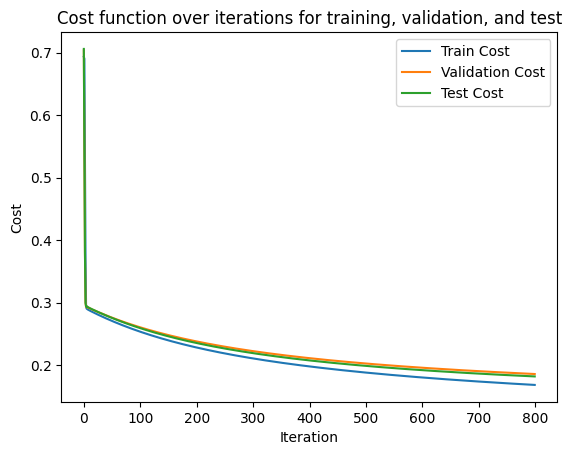

> Learning Rate: 0.01
---- Test Set Analysis ----
Test Accuracy:  0.6310679611650486
Test F1 Score:  0.6005900832369092

---- Validation Set Analysis ----
Validation Accuracy:  0.6225806451612903
Validation F1 Score:  0.5921699290201985



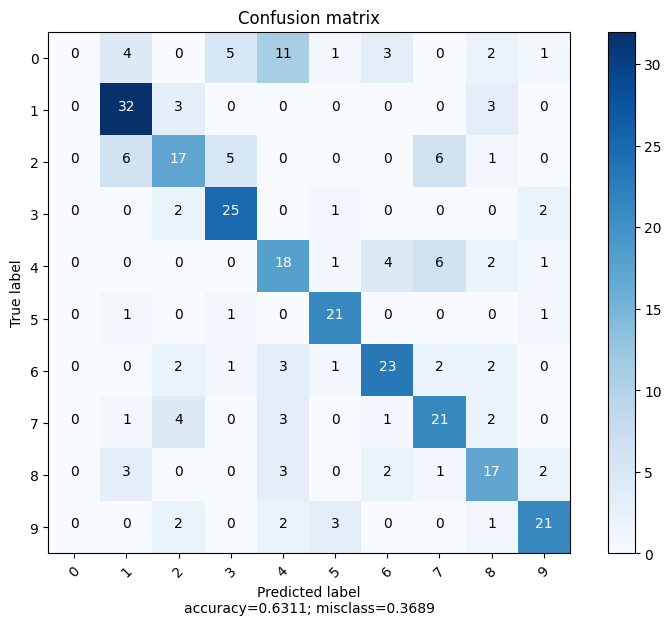

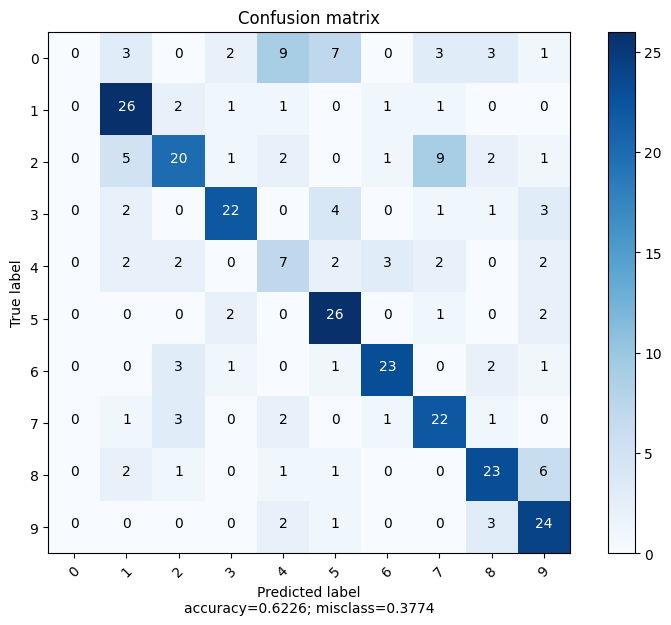

---- Train Set Classification Report ----
              precision    recall  f1-score   support

           0       0.00      0.00      0.00       150
           1       0.66      0.88      0.75       136
           2       0.69      0.68      0.69       130
           3       0.77      0.80      0.78       143
           4       0.51      0.61      0.56       155
           5       0.76      0.86      0.80       152
           6       0.68      0.75      0.71       142
           7       0.64      0.68      0.66       144
           8       0.73      0.79      0.76       146
           9       0.77      0.85      0.81       145

    accuracy                           0.69      1443
   macro avg       0.62      0.69      0.65      1443
weighted avg       0.62      0.69      0.65      1443

---- Test Set Classification Report ----
              precision    recall  f1-score   support

           0       0.00      0.00      0.00        27
           1       0.68      0.84      0.75      

/home/kernaite/Documents/TAA/venv/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/kernaite/Documents/TAA/venv/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/kernaite/Documents/TAA/venv/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()

In [26]:
#Number of features
features = X_train.shape[1]

print('Number of features: ', features)
print('Number of classes: ', Y_train.shape[1])

# Test with different learning rates
learning_rates = [0.01, 0.001] # 0.1, 0.3 are bad

theta = np.zeros((features+1, 1))  # +1 para o termo de interceptação

# Number of iterations
num_iters = 800

print(X_train.shape)
print(Y_train.shape)
print(theta.shape)

#Lambda
Lambda = 0.1
K = 10

# Train and analyze the model
all_theta = train_and_analyze(trainOneVsAll, predictOneVsAll, X_train, Y_train, X_test, Y_test, X_val, Y_val, learning_rates[0], num_iters, Lambda, K)

In [27]:
# # # PCA

# # # Standardize the data

# from sklearn.preprocessing import StandardScaler

# scaler = StandardScaler()

# # Fit on training set only.

# scaler.fit(X_train)

# # Apply transform to both the training set and the test set.

# X_train = scaler.transform(X_train)

# X_test = scaler.transform(X_test)

# X_val = scaler.transform(X_val)

# # # PCA Projection to 2D

# pca = PCA(n_components=2)

# X_train = pca.fit_transform(X_train)

# X_test = pca.transform(X_test)

# X_val = pca.transform(X_val)

# # # Train and Analyze

# from sklearn.linear_model import LogisticRegression

# model = LogisticRegression(max_iter=1000)

# trained_model = train_and_analyze(model, X_train, Y_train, X_test, Y_test)

# # # Cross Validation

# from sklearn.model_selection import cross_val_score

# scores = cross_val_score(model, X_train, Y_train, cv=5)

# print("Cross Validation Scores: ", scores)

# # # Hyperparameter Tuning
